# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.12.0-rho.new.339.357.359.362.366.367.383.fix.360.373'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Please set verbose=2 to see the detailed citation list.




Retrieving linelist from Open COVID-19 Data Working Group repository: https://github.com/beoutbreakprepared/nCoV2019


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


### Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

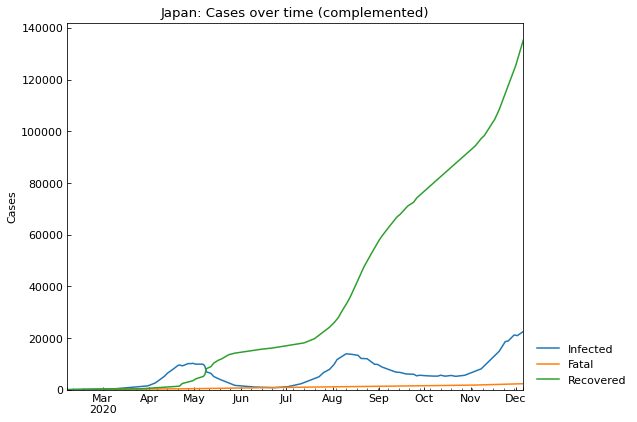

,Date,Confirmed,Infected,Fatal,Recovered
300,2020-12-02,150386,20910,2172,127304
301,2020-12-03,152827,21373,2213,129241
302,2020-12-04,155232,21816,2240,131176
303,2020-12-05,157674,21948,2283,133443
304,2020-12-06,160098,22506,2315,135277


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of new cases with `Scenario.record_diff()` method.

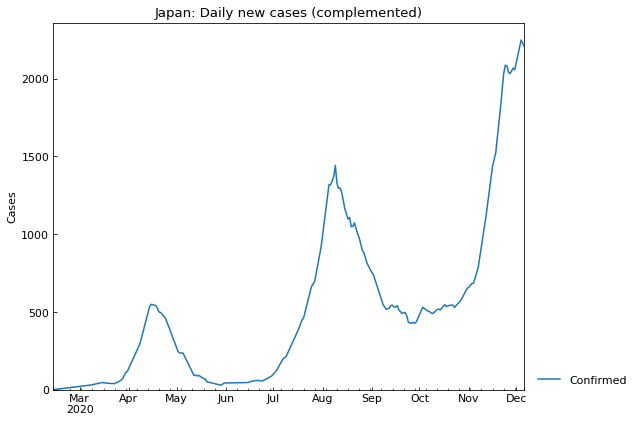

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

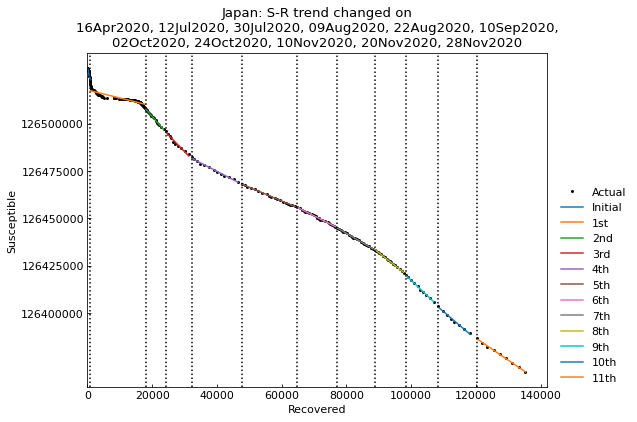

,Type,Start,End,Population
0th,Past,06Feb2020,15Apr2020,126529100
1st,Past,16Apr2020,11Jul2020,126529100
2nd,Past,12Jul2020,29Jul2020,126529100
3rd,Past,30Jul2020,08Aug2020,126529100
4th,Past,09Aug2020,21Aug2020,126529100
5th,Past,22Aug2020,09Sep2020,126529100
6th,Past,10Sep2020,01Oct2020,126529100
7th,Past,02Oct2020,23Oct2020,126529100
8th,Past,24Oct2020,09Nov2020,126529100
9th,Past,10Nov2020,19Nov2020,126529100


In [8]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [9]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	11th phase (28Nov2020 - 06Dec2020): finished  329 trials in 0 min 10 sec


	 2nd phase (10Nov2020 - 19Nov2020): finished  368 trials in 0 min 10 sec

	 9th phase (10Sep2020 - 01Oct2020): finished  672 trials in 0 min 20 sec

	 7th phase (24Oct2020 - 09Nov2020): finished 3568 trials in 3 min  0 sec

	 8th phase (09Aug2020 - 21Aug2020): finished 3554 trials in 3 min  0 sec

	 3rd phase (02Oct2020 - 23Oct2020): finished 3551 trials in 3 min  0 sec

	 0th phase (06Feb2020 - 15Apr2020): finished 3495 trials in 3 min  0 sec

	 4th phase (12Jul2020 - 29Jul2020): finished 3488 trials in 3 min  0 sec

	 5th phase (20Nov2020 - 27Nov2020): finished 3491 trials in 3 min  0 sec

	 6th phase (22Aug2020 - 09Sep2020): finished  353 trials in 0 min 10 sec

	10th phase (30Jul2020 - 08Aug2020): finished 3470 trials in 3 min  0 sec

	 1st phase (16Apr2020 - 11Jul2020): finished 3442 trials in 3 min  0 sec

Completed optimization. Total: 6 min 32 sec


In [10]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/gamma [day],1/beta [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,06Feb2020,15Apr2020,126529100,SIR-F,4.55,0.018619,0.000694,0.104040,0.021763,1440,1441,45,9,0.019,0.255293,3495,3 min 0 sec
1st,Past,16Apr2020,11Jul2020,126529100,SIR-F,0.53,0.106333,0.000009,0.032864,0.055854,1440,108732,17,30,0.106,0.334906,3442,3 min 0 sec
2nd,Past,12Jul2020,29Jul2020,126529100,SIR-F,1.96,0.000086,0.000144,0.134213,0.068216,1440,6927,14,7,0.000,0.018873,3488,3 min 0 sec
3rd,Past,30Jul2020,08Aug2020,126529100,SIR-F,1.93,0.000961,0.000181,0.135505,0.069904,1440,5514,14,7,0.001,0.028915,3470,3 min 0 sec
4th,Past,09Aug2020,21Aug2020,126529100,SIR-F,0.95,0.000657,0.000591,0.083644,0.086994,1440,1690,11,11,0.001,0.026354,3554,3 min 0 sec
5th,Past,22Aug2020,09Sep2020,126529100,SIR-F,0.71,0.016946,0.000191,0.067507,0.093305,1440,5243,10,14,0.017,0.017620,353,0 min 10 sec
6th,Past,10Sep2020,01Oct2020,126529100,SIR-F,0.88,0.000495,0.001355,0.085241,0.095526,1440,738,10,11,0.000,0.018874,672,0 min 20 sec
7th,Past,02Oct2020,23Oct2020,126529100,SIR-F,0.99,0.001063,0.000853,0.107514,0.107768,1440,1172,9,9,0.001,0.013874,3551,3 min 0 sec
8th,Past,24Oct2020,09Nov2020,126529100,SIR-F,1.28,0.000995,0.001051,0.112943,0.086965,1440,951,11,8,0.001,0.019773,3568,3 min 0 sec
9th,Past,10Nov2020,19Nov2020,126529100,SIR-F,1.66,0.002495,0.000463,0.134192,0.080025,1440,2159,12,7,0.002,0.011489,368,0 min 10 sec


### Accuracy of estimation

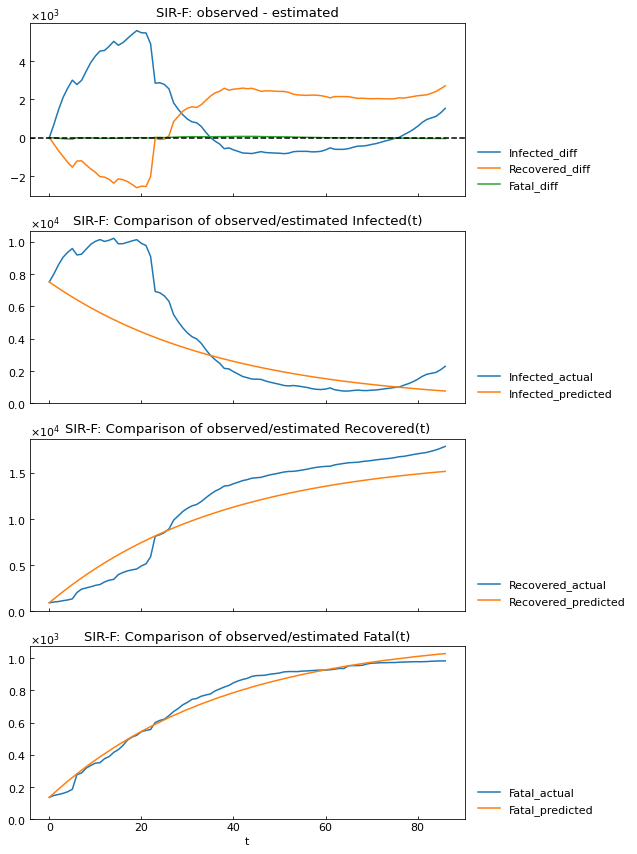

In [11]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [12]:
snl.get("Rt", phase="4th")

0.95

### Show parameter history

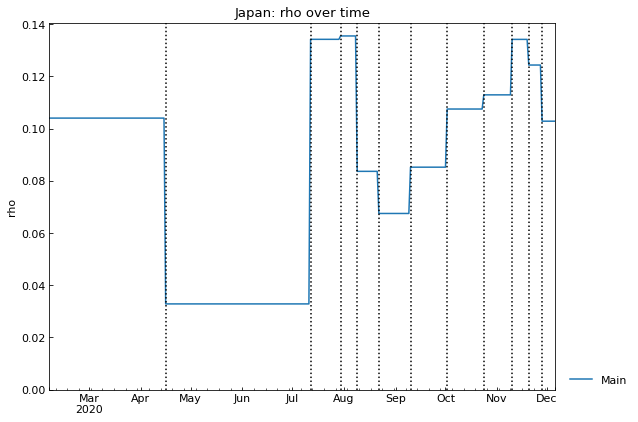

In [13]:
_ = snl.history(target="rho")

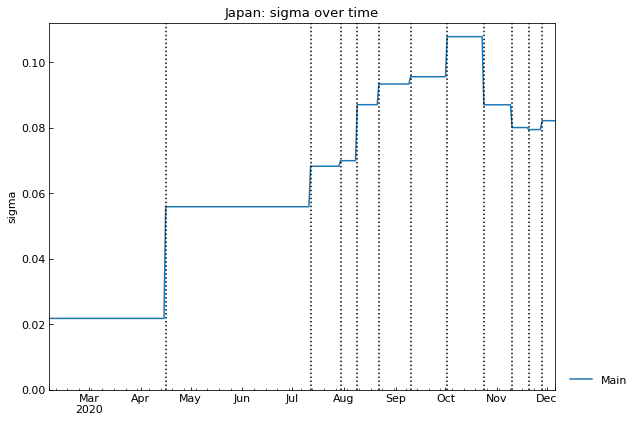

In [14]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

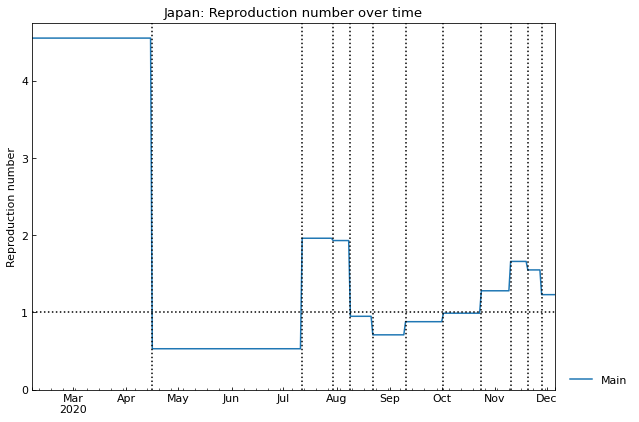

In [15]:
_ = snl.history(target="Rt")

### Simulate the number of cases

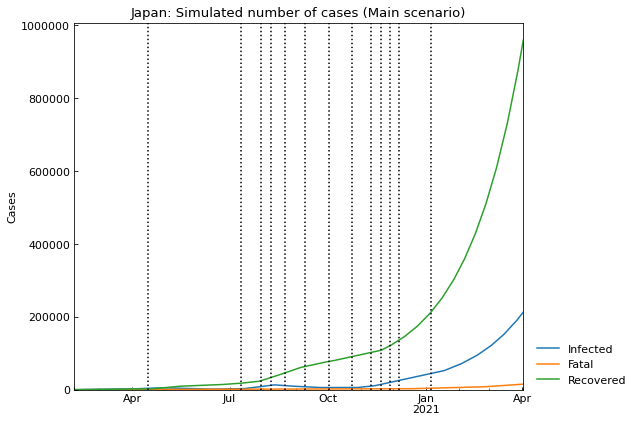

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,1104174,14186,197781,892207
418,2021-03-30,1124531,14444,201485,908602
419,2021-03-31,1145263,14706,205255,925302
420,2021-04-01,1166377,14973,209091,942313
421,2021-04-02,1187882,15244,212996,959642


In [16]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [17]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.08211175223216469

In [18]:
sigma_new = sigma_current * 2
sigma_new

0.16422350446432937

In [19]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  15Apr2020   126529100  SIR-F  4.55   
         1st      Past  16Apr2020  11Jul2020   126529100  SIR-F  0.53   
         2nd      Past  12Jul2020  29Jul2020   126529100  SIR-F  1.96   
         3rd      Past  30Jul2020  08Aug2020   126529100  SIR-F  1.93   
         4th      Past  09Aug2020  21Aug2020   126529100  SIR-F  0.95   
         5th      Past  22Aug2020  09Sep2020   126529100  SIR-F  0.71   
         6th      Past  10Sep2020  01Oct2020   126529100  SIR-F  0.88   
         7th      Past  02Oct2020  23Oct2020   126529100  SIR-F  0.99   
         8th      Past  24Oct2020  09Nov2020   126529100  SIR-F  1.28   
         9th      Past  10Nov2020  19Nov2020   126529100  SIR-F  1.66   
         10th     Past  20Nov2020  27Nov2020   126529100  SIR-F  1.55   
         11th     Past  28Nov2020  06Dec2020   126529100  SIR-F  1.23   
         12th   Future  07Dec2020  05Jan2021   126529100  SIR-F  1.23   
         13th   Future  06Jan2021  01Apr2021   126529100  SIR-F  1.23   
Medicine 0th      Past  06Feb2020  15Apr2020   126529100  SIR-F  4.55   
         1st      Past  16Apr2020  11Jul2020   126529100  SIR-F  0.53   
         2nd      Past  12Jul2020  29Jul2020   126529100  SIR-F  1.96   
         3rd      Past  30Jul2020  08Aug2020   126529100  SIR-F  1.93   
         4th      Past  09Aug2020  21Aug2020   126529100  SIR-F  0.95   
         5th      Past  22Aug2020  09Sep2020   126529100  SIR-F  0.71   
         6th      Past  10Sep2020  01Oct2020   126529100  SIR-F  0.88   
         7th      Past  02Oct2020  23Oct2020   126529100  SIR-F  0.99   
         8th      Past  24Oct2020  09Nov2020   126529100  SIR-F  1.28   
         9th      Past  10Nov2020  19Nov2020   126529100  SIR-F  1.66   
         10th     Past  20Nov2020  27Nov2020   126529100  SIR-F  1.55   
         11th     Past  28Nov2020  06Dec2020   126529100  SIR-F  1.23   
         12th   Future  07Dec2020  05Jan2021   126529100  SIR-F  1.23   
         13th   Future  06Jan2021  01Apr2021   126529100  SIR-F  0.62   

                   theta     kappa       rho     sigma   tau  1/alpha2 [day]  \
Scenario Phase                                                                 
Main     0th    0.018619  0.000694  0.104040  0.021763  1440            1441   
         1st    0.106333  0.000009  0.032864  0.055854  1440          108732   
         2nd    0.000086  0.000144  0.134213  0.068216  1440            6927   
         3rd    0.000961  0.000181  0.135505  0.069904  1440            5514   
         4th    0.000657  0.000591  0.083644  0.086994  1440            1690   
         5th    0.016946  0.000191  0.067507  0.093305  1440            5243   
         6th    0.000495  0.001355  0.085241  0.095526  1440             738   
         7th    0.001063  0.000853  0.107514  0.107768  1440            1172   
         8th    0.000995  0.001051  0.112943  0.086965  1440             951   
         9th    0.002495  0.000463  0.134192  0.080025  1440            2159   
         10th   0.000736  0.000713  0.124368  0.079407  1440            1403   
         11th   0.000671  0.001220  0.102858  0.082112  1440             819   
         12th   0.000671  0.001220  0.102858  0.082112  1440             819   
         13th   0.000671  0.001220  0.102858  0.082112  1440             819   
Medicine 0th    0.018619  0.000694  0.104040  0.021763  1440            1441   
         1st    0.106333  0.000009  0.032864  0.055854  1440          108732   
         2nd    0.000086  0.000144  0.134213  0.068216  1440            6927   
         3rd    0.000961  0.000181  0.135505  0.069904  1440            5514   
         4th    0.000657  0.000591  0.083644  0.086994  1440            1690   
         5th    0.016946  0.000191  0.067507  0.093305  1440            5243   
         6th    0.000495  0.001355  0.085241  0.095526  1440       

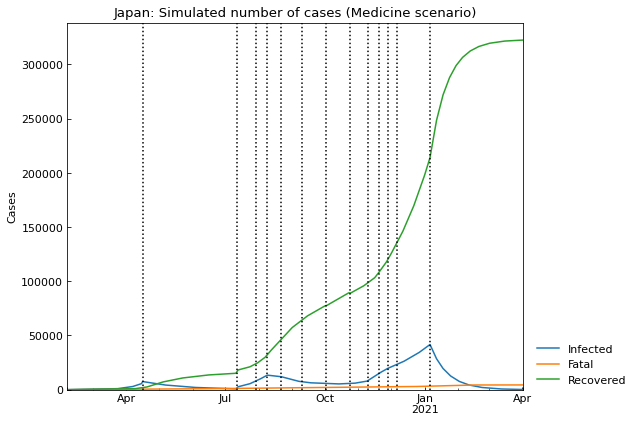

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,327018,4396,241,322381
418,2021-03-30,327042,4396,227,322419
419,2021-03-31,327065,4397,213,322455
420,2021-04-01,327086,4397,200,322489
421,2021-04-02,327106,4397,188,322521


In [20]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [21]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,13th_Rt
Main,212996,02Apr2021,1187882,212996,15244,1.23
Medicine,41680,06Jan2021,327106,188,4397,0.62


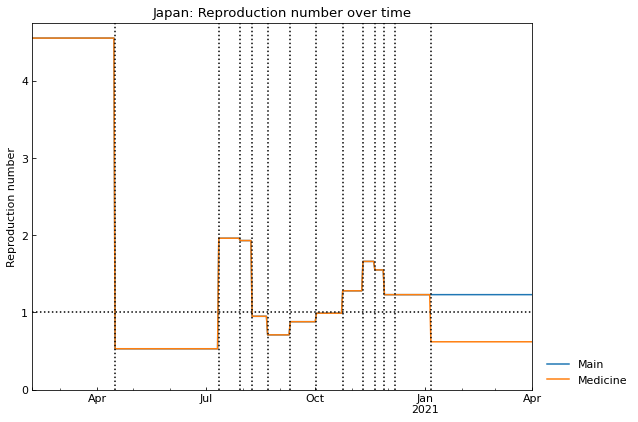

In [22]:
_ = snl.history(target="Rt")

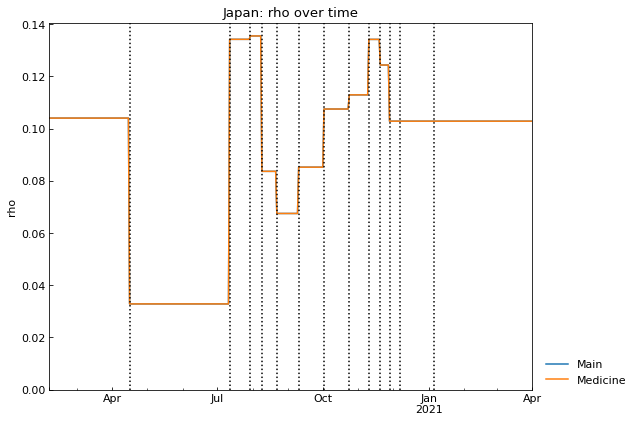

In [23]:
_ = snl.history(target="rho")

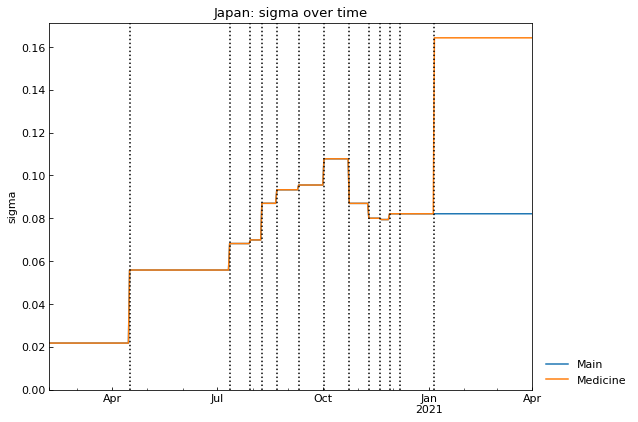

In [24]:
_ = snl.history(target="sigma")

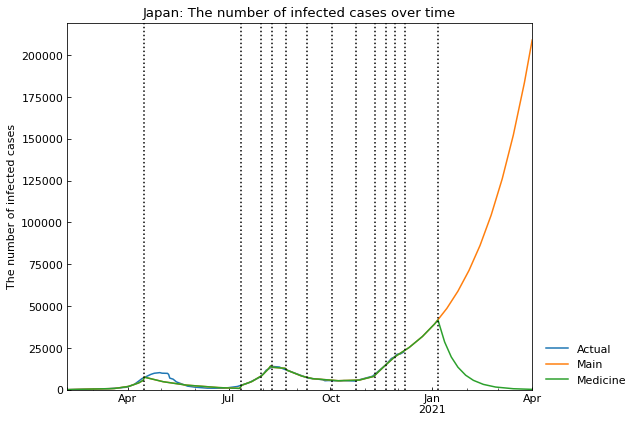

In [25]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

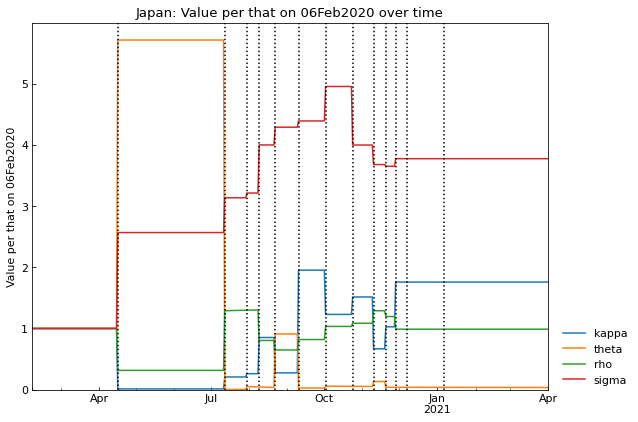

In [26]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [27]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (28Nov2020 - 06Dec2020): finished  327 trials in 0 min 10 sec


	 2nd phase (10Nov2020 - 19Nov2020): finished  362 trials in 0 min 10 sec

	 9th phase (10Sep2020 - 01Oct2020): finished  637 trials in 0 min 20 sec

	 7th phase (24Oct2020 - 09Nov2020): finished 3327 trials in 3 min  0 sec

	 8th phase (09Aug2020 - 21Aug2020): finished 3333 trials in 3 min  0 sec

	 3rd phase (02Oct2020 - 23Oct2020): finished 3304 trials in 3 min  0 sec

	 0th phase (06Feb2020 - 15Apr2020): finished 3276 trials in 3 min  0 sec

	10th phase (01Sep2020 - 09Sep2020): finished  326 trials in 0 min 10 sec

	 4th phase (12Jul2020 - 29Jul2020): finished 3265 trials in 3 min  0 sec

	 5th phase (20Nov2020 - 27Nov2020): finished 3273 trials in 3 min  0 sec

	 1st phase (30Jul2020 - 08Aug2020): finished 3273 trials in 3 min  0 sec

	11th phase (16Apr2020 - 11Jul2020): finished 3218 trials in 3 min  0 sec

	 6th phase (22Aug2020 - 31Aug2020): finished  621 trials in 0 min 20 sec

Completed optimization. Total: 6 min 32 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 6th phase (01Sep2020 - 06Dec2020): finished 10497 trials in 3 min  0 sec

Completed optimization. Total: 3 min  1 sec


In [28]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  15Apr2020  SIR-F  4.55  0.018619  0.000694   
              1st    16Apr2020  11Jul2020  SIR-F  0.53  0.106333  0.000009   
              2nd    12Jul2020  29Jul2020  SIR-F  1.96  0.000086  0.000144   
              3rd    30Jul2020  08Aug2020  SIR-F  1.93  0.000961  0.000181   
              4th    09Aug2020  21Aug2020  SIR-F  0.95  0.000657  0.000591   
              5th    22Aug2020  31Aug2020  SIR-F  0.74  0.000372  0.001066   
              6th    01Sep2020  09Sep2020  SIR-F  0.67  0.000813  0.001420   
              7th    10Sep2020  01Oct2020  SIR-F  0.88  0.000495  0.001355   
              8th    02Oct2020  23Oct2020  SIR-F  0.99  0.001063  0.000853   
              9th    24Oct2020  09Nov2020  SIR-F  1.28  0.000995  0.001051   
              10th   10Nov2020  19Nov2020  SIR-F  1.66  0.002495  0.000463   
              11th   20Nov2020  27Nov2020  SIR-F  1.55  0.000736  0.000713   
              12th   28Nov2020  06Dec2020  SIR-F  1.23  0.000671  0.001220   
Retrospective 0th    06Feb2020  15Apr2020  SIR-F  4.55  0.018619  0.000694   
              1st    16Apr2020  11Jul2020  SIR-F  0.53  0.106333  0.000009   
              2nd    12Jul2020  29Jul2020  SIR-F  1.96  0.000086  0.000144   
              3rd    30Jul2020  08Aug2020  SIR-F  1.93  0.000961  0.000181   
              4th    09Aug2020  21Aug2020  SIR-F  0.95  0.000657  0.000591   
              5th    22Aug2020  31Aug2020  SIR-F  0.74  0.000372  0.001066   
              6th    01Sep2020  06Dec2020  SIR-F  0.74  0.000372  0.001066   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.104040  0.021763  0.255293    3276  3 min  0 sec  
              1st    0.032864  0.055854  0.334906    3218  3 min  0 sec  
              2nd    0.134213  0.068216  0.018873    3265  3 min  0 sec  
              3rd    0.135505  0.069904  0.028915    3273  3 min  0 sec  
              4th    0.083644  0.086994  0.026354    3333  3 min  0 sec  
              5th    0.069895  0.092914  0.014808     621  0 min 20 sec  
              6th    0.066253  0.097965  0.013812     326  0 min 10 sec  
              7th    0.085241  0.095526  0.018874     637  0 min 20 sec  
              8th    0.107514  0.107768  0.013874    3304  3 min  0 sec  
              9th    0.112943  0.086965  0.019773    3327  3 min  0 sec  
              10th   0.134192  0.080025  0.011489     362  0 min 10 sec  
              11th   0.124368  0.079407  0.022143    3273  3 min  0 sec  
              12th   0.102858  0.082112  0.012688     327  0 min 10 sec  
Retrospective 0th    0.104040  0.021763  0.255293    3276  3 min  0 sec  
              1st    0.032864  0.055854  0.334906    3218  3 min  0 sec  
              2nd    0.134213  0.068216  0.018873    3265  3 min  0 sec  
              3rd    0.135505  0.069904  0.028915    3273  3 min  0 sec  
              4th    0.083644  0.086994  0.026354    3333  3 min  0 sec  
              5th    0.069895  0.092914  0.014808     621  0 min 20 sec  
              6th    0.069895  0.092914  0.851569   10497  3 min  0 sec

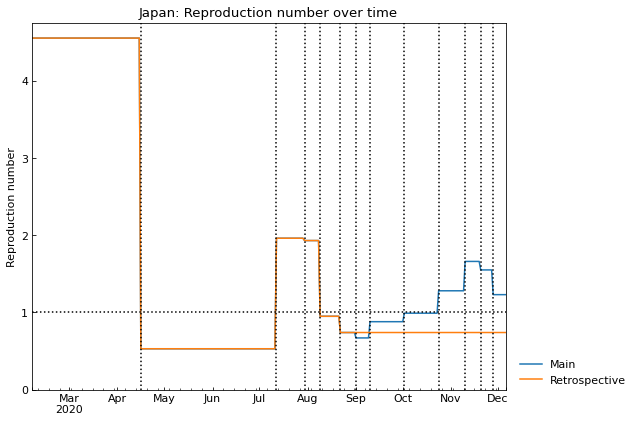

In [29]:
# History of reproduction number
_ = snl_retro.history("Rt")

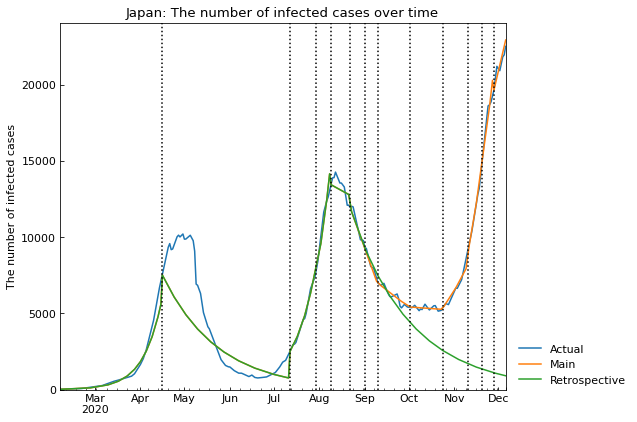

In [30]:
# History of Infected
_ = snl_retro.history("Infected")

In [31]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 07Dec2020,Infected on 07Dec2020,Fatal on 07Dec2020,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,23367,07Dec2020,161899,23367,2323,0.67,0.88,0.99,1.28,1.66,1.55,1.23
Retrospective,14151,08Aug2020,92629,892,1675,0.74,-,-,-,-,-,-
